#### This notebook shows how to read the fastMRI dataset and apply some simple transformations to the data.

In [27]:
# Testing if integration works

In [58]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt

The fastMRI dataset is distributed as a set of HDF5 files and can be read with the h5py package. Here, we show how to open a file from the multi-coil dataset. Each file corresponds to one MRI scan and contains the k-space data, ground truth and some meta data related to the scan.

In [135]:
file_name = '../data/singlecoil_train/file1000002.h5'
#file_name2 = '../data/singlecoil_test/file1000022.h5'
#file_name3 = '../data/singlecoil_test/file1000055.h5'
hf = h5py.File(file_name)
#hf2 = h5py.File(file_name2)
#hf3 = h5py.File(file_name3)

In [136]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']
Attrs: {'acquisition': 'CORPDFS_FBK', 'max': 0.00017650825327941136, 'norm': 0.05959661790940469, 'patient_id': 'eb7618a8d0fe9c3d61f073296ec71e5fe7cf643fe14a81a45ff6480c3d037d83'}


In multi-coil MRIs, k-space has the following shape:
(number of slices, number of coils, height, width)

For single-coil MRIs, k-space has the following shape:
(number of slices, height, width)

MRIs are acquired as 3D volumes, the first dimension is the number of 2D slices.

In [137]:
volume_kspace = hf['kspace'][()]
#volume_kspace2 = hf2['kspace'][()]
#volume_kspace3 = hf3['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)

complex64
(38, 640, 368)


In [138]:
slice_kspace = volume_kspace

Let's see what the absolute value of k-space looks like:

In [139]:
def show_multiple_slices(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

In [140]:
#def show_slice(data, cmap=None):
    #fig = plt.figure()
    #plt.imshow(data, cmap=cmap)

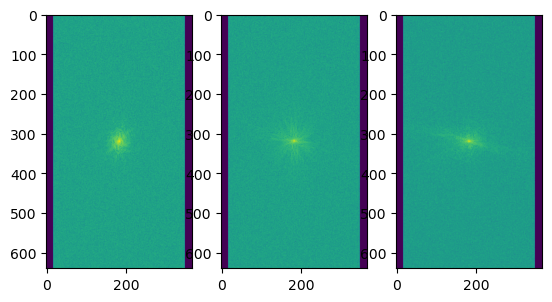

In [141]:
show_multiple_slices(np.log(np.abs(slice_kspace) + 1e-9), [10,20,30]) 

The fastMRI repo contains some utlity functions to convert k-space into image space. These functions work on PyTorch Tensors. The to_tensor function can convert Numpy arrays to PyTorch Tensors.

In [142]:
import fastmri
from fastmri.data import transforms as T

In [143]:
slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image

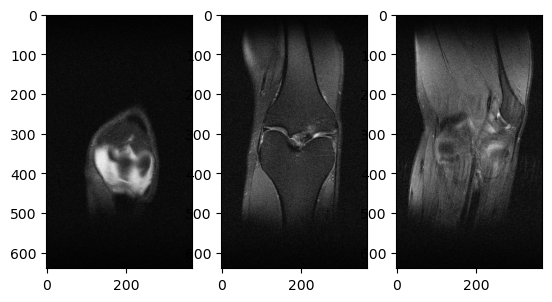

In [144]:
show_multiple_slices(slice_image_abs, [10,20,30], cmap='gray')

MR imaging is an indirect process, whereby cross-sectional images of the subject’s anatomy are
produced from frequency and phase measurements instead of direct, spatially-resolved measurements. As we can see, each image in the dataset focuses on a different snapshot of the subject's anatomy. These slices can be combined into the full image using the Root-Sum-of-Squares (RSS) transform.

In [145]:
slice_image_rss = fastmri.rss(slice_image_abs, dim=0)

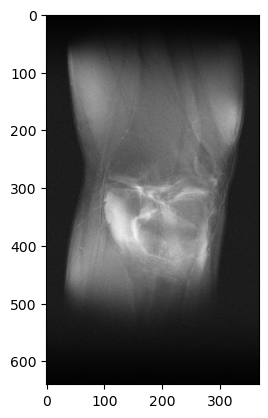

In [146]:
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')

So far, we have been looking at fully-sampled data. We can simulate under-sampled data by creating a mask and applying it to k-space.

In [147]:
from fastmri.data.subsample import RandomMaskFunc
mask_func = RandomMaskFunc(center_fractions=[0.04], accelerations=[8])  # Create the mask function object

In [148]:
masked_kspace, mask, _ = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space

Let's see what the subsampled image looks like:

In [149]:
sampled_image = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)

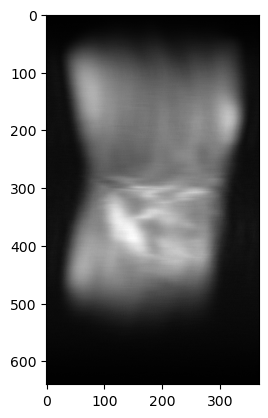

In [150]:
plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray')